In [1]:
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import random

In [48]:
n = 100
pts = np.array([np.random.uniform([-20, -20, 0], [20, 20, 5]) for _ in range(n)]) # Generate Nodes
pos = {i: pts[i] for i in range(n)}
G = nx.random_geometric_graph(n, radius=7, pos=pos, dim=3).to_undirected()

for u, v in G.edges:  # Add edges to graph    
    distance = np.linalg.norm(G.nodes[v]['pos'] - G.nodes[u]['pos'])
    G.edges[u, v]['distance'] = distance

In [49]:
elevations = [G.nodes[i]['pos'][2] for i in G.nodes]  # Get all the elevations
treatment_idxs = np.argsort(elevations)[:20]  # Get the indices of the 5 lowest elevation nodes

for i in G.nodes:  # Add treatment attribute to Graph
    if i in treatment_idxs:
        G.nodes[i]['treatment'] = 1
    else:
        G.nodes[i]['treatment'] = 0

# Store treatment and source nodes for use later
treatment_nodes = [i for i in G.nodes if G.nodes[i]['treatment'] == 1]  # use i
source_nodes = [j for j in G.nodes if G.nodes[j]['treatment'] == 0]  # use j

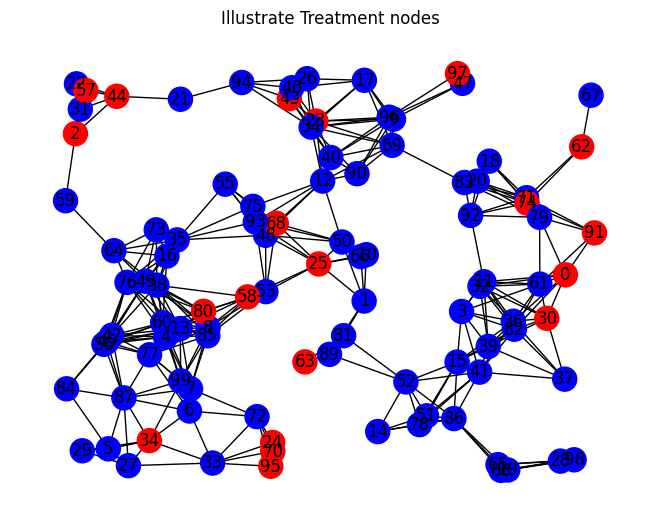

In [50]:
node_colors = ['red' if G.nodes[node]['treatment'] == 1 else 'blue' for node in G.nodes]
nx.draw(G, with_labels=True, pos=[G.nodes[node]['pos'][:2] for node in G.nodes], node_color=node_colors)
plt.title("Illustrate Treatment nodes")
plt.show()

In [51]:
print(f"# Source: {len(source_nodes)}; # treatment: {len(treatment_nodes)}; # Components = {nx.number_connected_components(G)}")

# Source: 80; # treatment: 20; # Components = 1


In [83]:
Path = {}  # Set of shortest paths from each source node i to each treatment node j
NLinks = {}  # Number of edges in each path
L = {}  # Length of each path (distance)

for i in source_nodes:
    for j in treatment_nodes:
        path = nx.shortest_path(G, source=i, target=j, weight='distance')
        Path[i, j] = path
        NLinks[i, j] = len(path)-1
        L[i, j] = nx.path_weight(G, path, weight='distance')

In [53]:
LE = {e: G.edges[e]['distance'] for e in G.edges}  # Length of edge e
EL = {v: G.nodes[v]['pos'][2] for v in G.nodes}  # Elevation of node v

D = [0.2, 0.25, 0.3, 0.35, 0.40, 0.45]  # Pipe diameters
SR = {}  # Production at Source node i
CAP = {}  # Capacity at treatment node j

for node in source_nodes:
    flow = np.random.normal(1, 0.1)
    G.nodes[node]['production'] = flow
    SR[node] = flow

total_flow = sum(SR.values())

for node in treatment_nodes:
    capacity = 2 * (total_flow / len(treatment_nodes))
    G.nodes[node]['capacity'] = capacity
    CAP[node] = capacity

Vmin = 0.6
Vmax = 3
CE = 25  # Cost of Excavation
CB = 6  # Cost of Bedding
TR = 44000  # Fixed Cost of Treatment Plant
TRFlow = 100  # Variable Cost of Treatment
PICost = 30  

PF = {'0.05': 8.7, '0.06': 9.5, '0.08': 11,
                       '0.1': 12.6, '0.15': 43.5, '0.2': 141,
                       '0.25': 151, '0.3': 161, '0.35': 180,
                       '0.4': 190, '0.45': 200}  # Fixed Cost of Piping

CT = 10000  # Cost of trucking
M = 1e10

In [10]:
m = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18


In [94]:
# DECISION VARIABLES

x = m.addVars(Path.keys(), vtype=GRB.BINARY, name=[f'x_({i},{j})' for i, j in Path.keys()])
y = m.addVars(treatment_nodes, vtype=GRB.BINARY, name=[f'y_{j}' for j in treatment_nodes])
z = m.addVars((frozenset(e) for e in G.edges), vtype=GRB.BINARY, name=[f'z_{e}' for e in G.edges])


d_es_names = []
for e in G.edges:
    for s in D:
        d_es_names.append(f"d_{s}_{e}")
d_es = m.addVars(D, G.edges, vtype=GRB.BINARY, name=d_es_names)

r = m.addVars(G.nodes, vtype=GRB.CONTINUOUS, lb=0.0, ub=SR, name=[f'r_{v}' for v in G.nodes])
Q = m.addVars(G.edges, vtype=GRB.CONTINUOUS, lb=0.0, name=[f'q_{e}' for e in G.edges])

e_in = m.addVars(G.nodes, vtype=GRB.CONTINUOUS, lb=0.0, name=[f'e_in_{v}' for v in G.nodes])
e_out = m.addVars(G.nodes, vtype=GRB.CONTINUOUS, lb=0.0, name=[f'e_out_{v}' for v in G.nodes])
h = m.addVars(G.nodes, vtype=GRB.CONTINUOUS, name=[f'h_{v}' for v in G.nodes])
m.update()

In [56]:
# CONSTRAINTS

# TREATMENT CAPACITY
treat_cap = m.addConstrs(gp.quicksum(SR[i] * x[i, j] - r[i] for i in source_nodes) <= CAP[j]*y[j] for j in treatment_nodes)

#  NODE ASSIGNMENT
node_assign = m.addConstrs(gp.quicksum(x[i, j] for j in treatment_nodes) == 1 for i in source_nodes)

In [84]:
Path_e = {}  # Use this for Edge Activiation Constraint
for e, p in Path.items():
    Path_e[e] = [(p[l-1], p[l]) for l in range(1, len(p))]

In [99]:
# EDGE ACTIVATION
for i, j in Path.keys():
    m.addConstr(gp.quicksum(z[frozenset(e)] for e in Path_e[i, j]) >= NLinks[i, j] * x[i, j])
    
    
# edge_activate = m.addConstrs(gp.quicksum(z[e] for e in Path_e[i, j]) >= NLinks[i, j] * x[i, j] for i, j in Path)

# TODO: Need edge-wise path

In [98]:
# PIPE SIZING

pipe_sizing = m.addConstrs(gp.quicksum(d_es[s, *e] for s in D) == 1 for e in G.edges)

In [100]:
# HEIGHT DIFFERENCE
height = m.addConstrs(h[i] == e_out[i] - e_in[i] for i in source_nodes)

# MINUMUM SLOPE

# MAXIMUM SLOPE

In [101]:
# FLOW VELOCITY LIMIT

# TODO: D structure needs to be fixed, and d_es should be renamed

flow_vel = m.addConstrs(Q[e] <= gp.quicksum((np.pi / 8) * (D[s]**2) * (d_es[D[s], *e]) for s in range(len(D))) for e in G.edges)

In [102]:
# MANNING'S EQUATION

# Create new variables for the squared terms
Q_squared = m.addVars(G.edges, name="Q_squared")

manning = m.addConstrs(
    (LE[u, v] * gp.quicksum(d_es[s, u, v] * Q_squared[u, v] / (11.9879 * (s**(8/3)))**2 for s in D) 
     <= e_in[u] - e_in[v] + h[u] for u, v in G.edges), 
    name="manning"
)

# Add constraints to enforce Q_squared[u, v] = Q[u, v]^2
q_square = m.addConstrs((Q_squared[u, v] == Q[u, v] * Q[u, v] for u, v in G.edges), name="Q_squared_def")

m.update()

In [103]:
# NO HEIGHT GAIN
height_gain = m.addConstrs(h[i] <= 0 for i in source_nodes)

# PIPES UNDERGROUND
underground = m.addConstrs(e_in[i] <= EL[i] for i in source_nodes)

In [104]:
m.update()

In [105]:
print(f"Model has {m.NumVars} variables and {m.NumConstrs} constraints.")

Model has 38429 variables and 4368 constraints.


In [ ]:
treat_cost = gp.LinExpr()

for j in treatment_nodes:
    treat_cost.addTerms(TR, y[j])
    for i in source_nodes:
        treat_cost.addTerms(TRFlow * SR[i], x[i, j])
# OBJECTIVE EXPR 2: EXCAVATION COSTS
excav_cost = gp.LinExpr()
# OBJECTIVE EXPR 3: BEDDING COSTS
bed_cost = gp.LinExpr()
# OBJECTIVE EXPR 4: RECOURSE TRUCKING

rec_cost = gp.LinExpr()
for i in source_nodes:
    rec_cost.addTerms(CT, r[i])